In [1]:
from util import setup_notebook
setup_notebook()
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import altair as alt

In [3]:
from testmining import cache
builds = cache.read('builds')
builds.head()

,tr_build_number,gh_project_name,gh_lang,gh_pull_req_num,gh_is_pr,git_branch,git_all_built_commits,gh_build_started_at,test_failures,tr_duration,tr_log_testduration,tr_log_buildduration
tr_build_id,,,,,,,,,,,,
106060,499,rails/rails,ruby,NaN,False,3-1-stable,"[ca26feb54aa7d994831fc33e23fd46adda73358c, 97e...",2011-08-29 00:25:49,False,156165.0,0.00,0.0
106176,498,rails/rails,ruby,NaN,False,master,"[cfe7548aef1b005e49eacd8b0177764e77643ccf, cfe...",2011-08-29 00:13:21,False,185910.0,0.00,0.0
106236,204,intridea/omniauth,ruby,NaN,False,master,"[b8041a817ab028ec73305c4cc2202882203562c4, b80...",2011-08-29 00:32:25,False,6210.0,8.24,0.0
106306,151,myronmarston/vcr,ruby,NaN,False,master,"[1a5a77084a79a1ca5d94a72bef307c2ae3ed47c5, 1a5...",2011-08-29 00:49:04,False,5952.0,283.81,0.0
106359,205,intridea/omniauth,ruby,NaN,False,master,"[abe1d1c9aa912c315904023ee6938191befbfb3b, abe...",2011-08-29 00:50:17,False,5418.0,7.59,0.0


In [4]:
# How many builds are part of a PR?
builds['gh_is_pr'].sum() / len(builds)

0.15225320452978422

In [5]:
pr_builds = builds[builds['gh_is_pr']]
len(pr_builds)

103564

In [6]:
# How many builds from pull requests have test failures?
pr_builds['test_failures'].sum() / len(pr_builds)

0.11334054304584605

In [7]:
# How many PRs have at least one build with a test failure?
pr_test_failures = pr_builds.groupby(['gh_project_name', 'gh_pull_req_num']).agg({
    'test_failures': 'any',
})

pr_test_failures['test_failures'].sum() / len(pr_test_failures)

0.11836299824517423

In [8]:
# How many PR are there?
len(pr_builds[['gh_project_name', 'gh_pull_req_num']].drop_duplicates())

79780

In [9]:
# What is the PR with most builds?
sizes = pr_builds.groupby(['gh_project_name', 'gh_pull_req_num']).agg('size')
sizes.idxmax(), sizes.max()

(('owncloud/android', 1224.0), 107)

In [10]:
# What is the project with most test failures in PRs?
project_failed_prs = pr_test_failures.groupby('gh_project_name')['test_failures'].agg('sum')
project_failed_prs.idxmax(), project_failed_prs.max()

('rails/rails', 1398.0)

In [11]:
# How many PRs exist for this particular project?
rails_pr_count = pr_builds[pr_builds['gh_project_name'] == 'rails/rails']['gh_pull_req_num'].count()
rails_pr_count

2089

In [12]:
# In individual projects, more than two third of PRs have at least one test failure.
project_failed_prs.max() / rails_pr_count

0.6692197223551939

In [13]:
# What is the distribution of relative failed PRs?

# TODO
# Example PR: https://github.com/BBC-News/wraith/pull/359
# 100% test failures, never merged
# filter PRs by resolve status? 'git_merged_with'


df = pr_builds.groupby(['gh_project_name', 'gh_pull_req_num']).agg({
    'test_failures': 'sum',
    'gh_pull_req_num': 'size',
}).rename(columns={'gh_pull_req_num': 'build_count'}).reset_index()

df['relative_failed_builds'] = df['test_failures'] / df['build_count']
display("many prs with no test failures", (df['test_failures'] == 0).sum())
display("many prs with all test failures", (df['relative_failed_builds'] == 1).sum())
display(df[df['relative_failed_builds'] == 1].head())
df = df[(df['test_failures'] > 0) & (df['relative_failed_builds'] < 1)]
display("just some failed prs", len(df))

'many prs with no test failures'

70337

'many prs with all test failures'

7805

,gh_project_name,gh_pull_req_num,test_failures,build_count,relative_failed_builds
307,BBC-News/wraith,261.0,1.0,1,1.0
328,BBC-News/wraith,359.0,6.0,6,1.0
606,Casecommons/pg_search,118.0,2.0,2,1.0
608,Casecommons/pg_search,138.0,1.0,1,1.0
609,Casecommons/pg_search,140.0,1.0,1,1.0


'just some failed prs'

1638

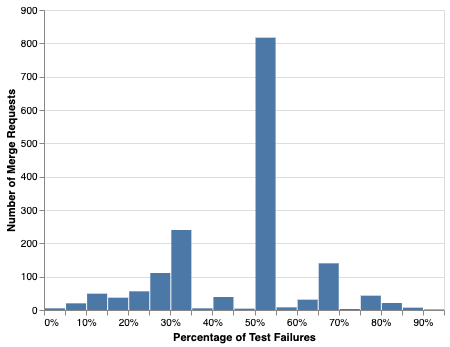

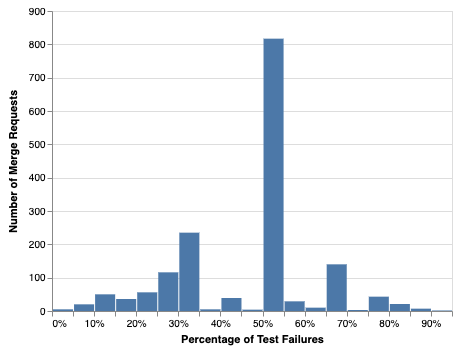

In [19]:
alt.Chart(df).mark_bar().encode(
    x=alt.X('relative_failed_builds',
            bin=alt.BinParams(step=0.05),
            title='Percentage of Test Failures',
            axis=alt.Axis(format='%')),
    y=alt.Y('count()', title='Number of Merge Requests'))

In [22]:
df['relative_failed_builds'].mean()

0.45062510942504896

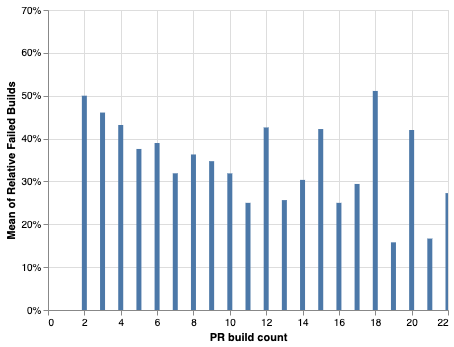

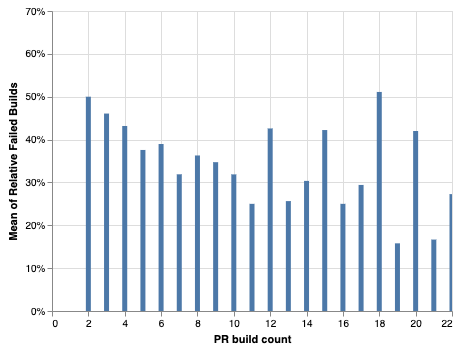

In [17]:
# If at least one (but not all builds) of a PR fail, how many builds are needed to 'correct' before merge?
# 
alt.Chart(df).mark_bar(clip=True).encode(
    x=alt.X('build_count', title='PR build count', scale=alt.Scale(domain=(1, 20))),
    y=alt.Y('mean(relative_failed_builds)',
            title='Mean of Relative Failed Builds',
            axis=alt.Axis(format='%'))
)

In [18]:
df.head()

,gh_project_name,gh_pull_req_num,test_failures,build_count,relative_failed_builds
28,Albacore/albacore,51.0,1.0,2,0.500000
52,ArturT/knapsack,1.0,1.0,2,0.500000
57,ArturT/knapsack,16.0,3.0,29,0.103448
314,BBC-News/wraith,297.0,1.0,2,0.500000
315,BBC-News/wraith,300.0,1.0,3,0.333333
